[View in Colaboratory](https://colab.research.google.com/github/zacateras/nn-nbirds/blob/master/roc_curve.ipynb)

In [0]:
# If python3 is not loaded kill the hypervisor
# ! kill -9 -1
import sys
sys.version

In [0]:
% cd ~

# Remove the environment
! if [ -d "nn-nbirds" ]; then rm -rf "nn-nbirds"; fi
# ! pip freeze | xargs pip uninstall -y

# Build the environment 
! git clone https://github.com/zacateras/nn-nbirds.git
% cd ./nn-nbirds

In [0]:
# Download the dataset
! ./data_tools/download.sh
! ./data_tools/split.sh

In [0]:
from preprocess import *

In [0]:
ds_meta = build_ds_meta()

for ds_meta_item in ds_meta:
    print('Quantity of %s: %s' % (ds_meta_item, ds_meta[ds_meta_item].count()[0]))

In [0]:
class Transform:
  def __init__(self, img, guid, ds_meta):
    self.img = img
    self.guid = guid
    self.ds_meta = ds_meta
  
  def resize(self):
      img = cv2.resize(self.img, (64, 64))
      return self
   
    
# BB + resize     => SET_A_RES_train
#                    SET_A_RES_validation
#                    SET_A_RES_test

apply(bounding_box, 'data/SET_A_train', 'data/SET_A_BB_train', ds_meta)
apply(bounding_box, 'data/SET_A_validation', 'data/SET_A_BB_validation', ds_meta)
apply(bounding_box, 'data/SET_A_test', 'data/SET_A_BB_test', ds_meta)

apply(lambda img, guid, dsm: Transform(img, guid, ds_meta).resize().img, 'data/SET_A_BB_train', 'data/SET_A_RES_train', ds_meta)
apply(lambda img, guid, dsm: Transform(img, guid, ds_meta).resize().img, 'data/SET_A_BB_validation', 'data/SET_A_RES_validation', ds_meta)
apply(lambda img, guid, dsm: Transform(img, guid, ds_meta).resize().img, 'data/SET_A_BB_test', 'data/SET_A_RES_test', ds_meta)

In [0]:
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import regularizers

In [0]:
train_dir = 'data/SET_A_RES_train'
validation_dir = 'data/SET_A_RES_validation'
test_dir = 'data/SET_A_RES_test'
no_of_classes = len(os.listdir('data/SET_A_RES_train'))

batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2)

test_datagen = ImageDataGenerator(
    rescale=1./255)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=batch_size,    
    shuffle=False,
    color_mode='rgb')

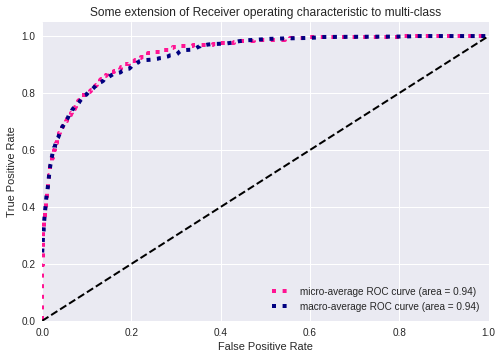

In [102]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from itertools import cycle
from keras.models import load_model

# ********** change model to print ROC ****************
model = load_model('cnn_models/cnn_512_descr_32_x_3_3_filt_128_batch_None_reg_120_epochs.h5')
# ****************************************************


lw = 2

y_score = model.predict_generator(test_generator, verbose=0)
y_test_v = test_generator.classes
n_classes = 50

y_test = np.zeros((len(y_test_v), n_classes))
for i in range(0, len(y_test_v)):
    y_test[i, y_test_v[i]] = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])   

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#draw_classes = 5
#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(draw_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()